In [1]:
from datetime import datetime
import math
import cv2
import glob
import numpy as np
from numpy import zeros, ones, vstack, hstack
from numpy.random import permutation
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/puneet6060/intel-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fratzcan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


100%|██████████| 346M/346M [00:00<00:00, 462MB/s]


In [3]:
import wandb

wandb.login(key = '4d975cec314dd2bfa52914355589e22b23c1fc6e')

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: firatozc (firatozc-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features

        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        self.slice5 = nn.Sequential()

        # VGG19'un katmanları üzerinde döngü
        for x in range(2):
            self.slice1.add_module(str(x), vgg[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg[x])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, X, Y):

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])
        X = normalize(X)
        Y = normalize(Y)

        # Özellik haritalarını çıkaralım
        h_X = self.slice1(X)
        h_Y = self.slice1(Y)
        loss1 = F.l1_loss(h_X, h_Y)

        h_X = self.slice2(h_X)
        h_Y = self.slice2(h_Y)
        loss2 = F.l1_loss(h_X, h_Y)

        h_X = self.slice3(h_X)
        h_Y = self.slice3(h_Y)
        loss3 = F.l1_loss(h_X, h_Y)

        h_X = self.slice4(h_X)
        h_Y = self.slice4(h_Y)
        loss4 = F.l1_loss(h_X, h_Y)

        h_X = self.slice5(h_X)
        h_Y = self.slice5(h_Y)
        loss5 = F.l1_loss(h_X, h_Y)

        return loss1 + loss2 + loss3 + loss4 + loss5

In [6]:
def RGB2LAB2(R0, G0, B0):
    R = R0 / 255
    G = G0 / 255
    B = B0 / 255

    Y = 0.299*R + 0.587*G + 0.114*B
    X = 0.449*R + 0.353*G + 0.198*B
    Z = 0.012*R + 0.089*G + 0.899*B

    L = Y
    a = (X - Y) / 0.234
    b = (Y - Z) / 0.785

    return L, a, b


def LAB22RGB(L, a, b, device):

    a11, a12, a13 = 0.299, 0.587, 0.114
    a21, a22, a23 = (0.15/0.234), (-0.234/0.234), (0.084/0.234)
    a31, a32, a33 = (0.287/0.785), (0.498/0.785), (-0.785/0.785)

    aa_np = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    aa_inv_tensor = torch.tensor(np.linalg.inv(aa_np), dtype=torch.float32).to(device)

    Lab = torch.cat((L, a, b), dim=1)

    batch_size, _, H, W = Lab.shape

    Lab_reshaped = Lab.view(batch_size, 3, -1)

    Lab_permuted = Lab_reshaped.permute(0, 2, 1)

    rgb_permuted = torch.matmul(Lab_permuted, aa_inv_tensor.t())

    rgb_reshaped = rgb_permuted.permute(0, 2, 1)
    rgb_image = rgb_reshaped.view(batch_size, 3, H, W)

    rgb_image = torch.clamp(rgb_image, 0.0, 1.0)

    return rgb_image

In [7]:
def psnr(img1, img2):
    mse = np.mean((img1.astype("float") - img2.astype("float")) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(imageA, imageB, bands):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    return err

def mae(imageA, imageB, bands):
    err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    return err

def rmse(imageA, imageB, bands):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    err = np.sqrt(err)
    return err

In [8]:
class DoubleConv(nn.Module):
    """Double Convolution Block"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [9]:
class TripleConv(nn.Module):
    """Triple Convolution Block"""
    def __init__(self, in_channels, out_channels):
        super(TripleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.triple_conv(x)


In [10]:
class UNet1(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(UNet1, self).__init__()

        # Encoder
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = TripleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = TripleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = TripleConv(512, 512)
        self.pool5 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv55 = TripleConv(512, 512)

        # Decoder
        self.up66 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv66 = DoubleConv(1024, 512)  # 512 + 512 from skip connection

        self.up6 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)  # 512 + 512 from skip connection

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)  # 256 + 256 from skip connection

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)  # 128 + 128 from skip connection

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)  # 64 + 64 from skip connection

        # Multi-scale feature fusion
        self.up_f02 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_f12 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final layers
        self.conv11 = nn.Conv2d(384, 128, kernel_size=3, padding=1)  # 64+64+128+128
        self.relu11 = nn.ReLU(inplace=True)

        self.conv12 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu12 = nn.ReLU(inplace=True)

        self.conv13 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu13 = nn.ReLU(inplace=True)

        self.conv14 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        x1 = self.pool1(conv1)

        conv2 = self.conv2(x1)
        x2 = self.pool2(conv2)

        conv3 = self.conv3(x2)
        x3 = self.pool3(conv3)

        conv4 = self.conv4(x3)
        x4 = self.pool4(conv4)

        conv5 = self.conv5(x4)
        x5 = self.pool5(conv5)

        # Bottleneck
        conv55 = self.conv55(x5)

        # Decoder
        up66 = self.up66(conv55)
        if up66.size()[2:] != conv5.size()[2:]:
            up66 = F.interpolate(up66, size=conv5.size()[2:], mode="bilinear", align_corners=True)
        merge66 = torch.cat([conv5, up66], dim=1)
        conv66 = self.conv66(merge66)

        up6 = self.up6(conv66)
        if up6.size()[2:] != conv4.size()[2:]:
            up6 = F.interpolate(up6, size=conv4.size()[2:], mode="bilinear", align_corners=True)
        merge6 = torch.cat([conv4, up6], dim=1)
        conv6 = self.conv6(merge6)

        up7 = self.up7(conv6)
        if up7.size()[2:] != conv3.size()[2:]:
            up7 = F.interpolate(up7, size=conv3.size()[2:], mode="bilinear", align_corners=True)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = self.conv7(merge7)

        up8 = self.up8(conv7)
        if up8.size()[2:] != conv2.size()[2:]:
            up8 = F.interpolate(up8, size=conv2.size()[2:], mode="bilinear", align_corners=True)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = self.conv8(merge8)

        up9 = self.up9(conv8)
        if up9.size()[2:] != conv1.size()[2:]:
            up9 = F.interpolate(up9, size=conv1.size()[2:], mode="bilinear", align_corners=True)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = self.conv9(merge9)


        # Multi-scale feature fusion
        up_f01 = conv1  # Original resolution
        up_f11 = conv9  # Decoded features
        up_f02 = self.up_f02(conv2)  # Upsampled encoder features
        up_f12 = self.up_f12(conv8)  # Upsampled decoder features

        # Concatenate multi-scale features
        merge11 = torch.cat([up_f01, up_f11, up_f02, up_f12], dim=1)

        # Final processing
        conv11 = self.relu11(self.conv11(merge11))
        conv12 = self.relu12(self.conv12(conv11))
        conv13 = self.relu13(self.conv13(conv12))
        output = self.tanh(self.conv14(conv13))

        return output

In [11]:
class ColorizationDataset(Dataset):
    def __init__(self, file_list, dim=150):
        self.file_list = file_list # image paths
        self.dim = dim

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Read image
        img_path = self.file_list[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.dim, self.dim))

        # Convert to LAB2
        sz0, sz1 = img.shape[:2]
        R1 = img[:, :, 0].reshape(-1, 1)
        G1 = img[:, :, 1].reshape(-1, 1)
        B1 = img[:, :, 2].reshape(-1, 1)

        # R1 = img[:, :, 2].reshape(-1, 1)  # Kırmızı kanal index 2'dedir
        # G1 = img[:, :, 1].reshape(-1, 1)  # Yeşil kanal index 1'dedir
        # B1 = img[:, :, 0].reshape(-1, 1)  # Mavi kanal index 0'dadır

        L, A, B = RGB2LAB2(R1, G1, B1)

        L = L.reshape(sz0, sz1, 1)
        A = A.reshape(sz0, sz1)
        B = B.reshape(sz0, sz1)

        ab = np.stack([A, B], axis=2)

        # Convert to tensors and normalize
        L_tensor = torch.FloatTensor(L).permute(2, 0, 1)  # (1, H, W)
        ab_tensor = torch.FloatTensor(ab).permute(2, 0, 1)  # (2, H, W)

        return L_tensor, ab_tensor


In [12]:
def load_vgg16_weights(model):
    """Load pretrained VGG16 weights to U-Net encoder"""
    vgg16 = models.vgg16(pretrained=True).to(device)
    vgg_features = vgg16.features

    # Adapt first layer from RGB to grayscale
    with torch.no_grad():
        # Get original RGB weights
        rgb_weights = vgg_features[0].weight
          # Shape: (64, 3, 3, 3)
        # Average across RGB channels
        gray_weights = rgb_weights.mean(dim=1, keepdim=True)  # Shape: (64, 1, 3, 3)

        # Set weights for first layer
        model.conv1.double_conv[0].weight.data = gray_weights
        model.conv1.double_conv[0].bias.data = vgg_features[0].bias.data

        # Set weights for second conv in first block
        model.conv1.double_conv[2].weight.data = vgg_features[2].weight.data
        model.conv1.double_conv[2].bias.data = vgg_features[2].bias.data

        # Second block
        model.conv2.double_conv[0].weight.data = vgg_features[5].weight.data
        model.conv2.double_conv[0].bias.data = vgg_features[5].bias.data
        model.conv2.double_conv[2].weight.data = vgg_features[7].weight.data
        model.conv2.double_conv[2].bias.data = vgg_features[7].bias.data

        # Third block (first two convs)
        model.conv3.triple_conv[0].weight.data = vgg_features[10].weight.data
        model.conv3.triple_conv[0].bias.data = vgg_features[10].bias.data
        model.conv3.triple_conv[2].weight.data = vgg_features[12].weight.data
        model.conv3.triple_conv[2].bias.data = vgg_features[12].bias.data
        model.conv3.triple_conv[4].weight.data = vgg_features[14].weight.data
        model.conv3.triple_conv[4].bias.data = vgg_features[14].bias.data

        # Fourth block
        model.conv4.triple_conv[0].weight.data = vgg_features[17].weight.data
        model.conv4.triple_conv[0].bias.data = vgg_features[17].bias.data
        model.conv4.triple_conv[2].weight.data = vgg_features[19].weight.data
        model.conv4.triple_conv[2].bias.data = vgg_features[19].bias.data
        model.conv4.triple_conv[4].weight.data = vgg_features[21].weight.data
        model.conv4.triple_conv[4].bias.data = vgg_features[21].bias.data

        # Fifth block
        model.conv5.triple_conv[0].weight.data = vgg_features[24].weight.data
        model.conv5.triple_conv[0].bias.data = vgg_features[24].bias.data
        model.conv5.triple_conv[2].weight.data = vgg_features[26].weight.data
        model.conv5.triple_conv[2].bias.data = vgg_features[26].bias.data
        model.conv5.triple_conv[4].weight.data = vgg_features[28].weight.data
        model.conv5.triple_conv[4].bias.data = vgg_features[28].bias.data


In [13]:
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Parameters
    dim = 150
    batch_size = 16
    epochs_max = 15
    max_nb_min = 3

    # Get current working directory and setup paths
    cwd = os.getcwd()

    base_path = "/content/intel-image-classification/seg_train/seg_train"
    # base_path = "/kaggle/working/intel-image-classification/seg_train/seg_train"

    classes = os.listdir(base_path)

    image_paths = []

    for cls in classes:
        folder_path = os.path.join(base_path, cls, "*.jpg")
        for file in glob.glob(folder_path):
            image_paths.append(file)


    base_path2 = "/content/intel-image-classification/seg_pred/seg_pred"

    # .jpg dosyalarının yolunu al
    jpg_files = glob.glob(os.path.join(base_path2, "*.jpg"))

    print(f"Toplam {len(jpg_files)} adet JPG dosyası bulundu.")

    image_paths = image_paths + jpg_files

    # Create model
    model = UNet1(in_channels=1, out_channels=2).to(device)

    # Load VGG16 pretrained weights
    print('Loading VGG16 pretrained weights...')
    load_vgg16_weights(model)

    # Loss function and optimizer
    # criterion = nn.L1Loss()  # Mean Absolute Error
    criterion = PerceptualLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=5.6008593690527854e-05)


    # Train/Val split
    train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

    # Dataset ve dataloader
    dataset = ColorizationDataset(train_paths, dim=dim)
    val_dataset = ColorizationDataset(val_paths, dim=dim)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


    # dataset = ColorizationDataset(image_paths, dim=dim)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Örnek: optimizer ve model tanımlandıktan sonra

    wandb.init(project="image_colorization", name="HyperUNet_experiment-Perceptual_Loss-Tracking_val_loss",
               config={
                   "batch_size": batch_size,
                   "epochs": epochs_max,
                   "learning_rate": 5.6008593690527854e-05,
                   "model_name": "HyperUNet-Intel-Image",
                   "optimizer": "Adam",
                   "loss_function": "PerceptualLoss",
                   "dataset": "Intel Image"
               })

    # Training tracking
    tr_acc = np.zeros((epochs_max, 2))
    time_tr = np.zeros((epochs_max, 2))
    mae_min = float('inf')
    nb_min = 0
    stop = 0


    train_losses = []
    val_losses = []

    print('Starting training...')

    for epoch in range(epochs_max):
      if stop:
          break

      start_time = datetime.now()
      model.train()

      total_loss = 0.0
      num_batches = 0

      # ----- TRAIN LOOP -----
      for batch_idx, (inputs, targets) in enumerate(dataloader):
          inputs, targets = inputs.to(device), targets.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)

          predicted_rgb = LAB22RGB(inputs, outputs[:, 0:1, :, :], outputs[:, 1:2, :, :], device)
          target_rgb    = LAB22RGB(inputs, targets[:, 0:1, :, :], targets[:, 1:2, :, :], device)

          loss = criterion(predicted_rgb, target_rgb)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          num_batches += 1

      avg_train_loss = total_loss / num_batches
      train_losses.append(avg_train_loss)

      # ----- VALIDATION LOOP -----
      model.eval()
      val_loss = 0.0
      val_batches = 0
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              outputs = model(inputs)

              predicted_rgb = LAB22RGB(inputs, outputs[:, 0:1, :, :], outputs[:, 1:2, :, :], device)
              target_rgb    = LAB22RGB(inputs, targets[:, 0:1, :, :], targets[:, 1:2, :, :], device)

              loss = criterion(predicted_rgb, target_rgb)
              val_loss += loss.item()
              val_batches += 1

      avg_val_loss = val_loss / val_batches
      val_losses.append(avg_val_loss)

      # ----- WANDB LOG -----
      wandb.log({
          "epoch": epoch+1,
          "train_loss": avg_train_loss,
          "val_loss": avg_val_loss
      })

      print(f"Epoch {epoch+1}/{epochs_max} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

      # Early stopping için artık avg_val_loss kullanabilirsin
      if avg_val_loss < mae_min:
          mae_min = avg_val_loss
          nb_min = 0
          torch.save(model.state_dict(), os.path.join(cwd, 'Hyper_U_NET_pytorch.pth'))
          print(f'New best model saved with val_loss: {mae_min:.6f}')
      else:
          nb_min += 1
          if nb_min > max_nb_min:
              stop = 1
              print('Early stopping triggered')


      # Plotting
      sns.set(style="whitegrid")

      plt.figure(figsize=(8,5))

      # Train loss
      plt.plot(train_losses, label="Train Loss",
                marker='o', markersize=5, markerfacecolor='white',
                linewidth=2, alpha=0.8)

      # Validation loss
      plt.plot(val_losses, label="Validation Loss",
                marker='s', markersize=5, markerfacecolor='white',
                linewidth=2, alpha=0.8)

      plt.xlabel("Epochs", fontsize=12)
      plt.ylabel("Loss", fontsize=12)
      plt.title("Train vs Validation Loss", fontsize=14, weight='bold')
      plt.legend(fontsize=10)
      plt.grid(True, linestyle='--', alpha=0.6)
      plt.tight_layout()
      plt.show()



In [16]:
def load_model_for_inference(model_path, device):
    """Load trained model for inference"""
    model = UNet1(in_channels=1, out_channels=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def inference(model, l_channel):
    """Perform inference on L channel to get ab channels"""
    # model.eval()
    # with torch.no_grad():
    #     if len(l_channel.shape) == 3:
    #         l_channel = l_channel.unsqueeze(0)  # Add batch dimension

    #     l_tensor = torch.FloatTensor(l_channel).to(device)
    #     ab_pred = model(l_tensor)

    #     return ab_pred.cpu().numpy()

    model.eval()

    with torch.no_grad():
          ab_pred = model(l_channel)

    return ab_pred.detach().cpu().numpy()



Toplam 7301 adet JPG dosyası bulundu.
Loading VGG16 pretrained weights...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 130MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:05<00:00, 108MB/s] 


Starting training...
Epoch 1/15 | Train Loss: 1.718770 | Val Loss: 1.657119
New best model saved with val_loss: 1.657119


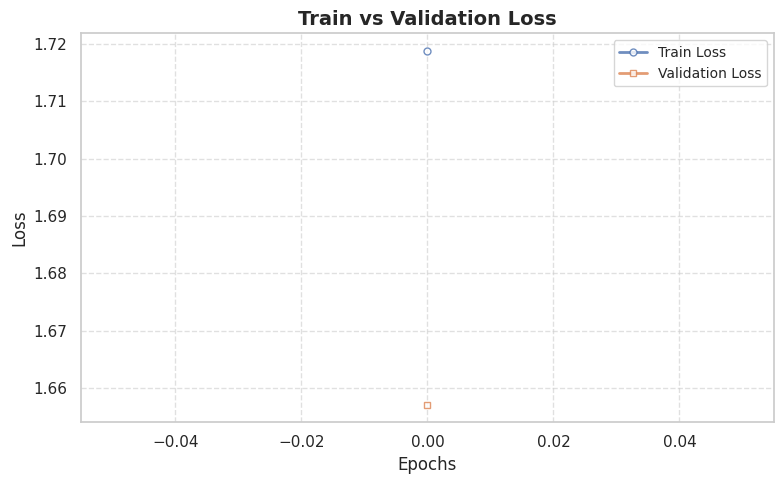

Epoch 2/15 | Train Loss: 1.641932 | Val Loss: 1.629932
New best model saved with val_loss: 1.629932


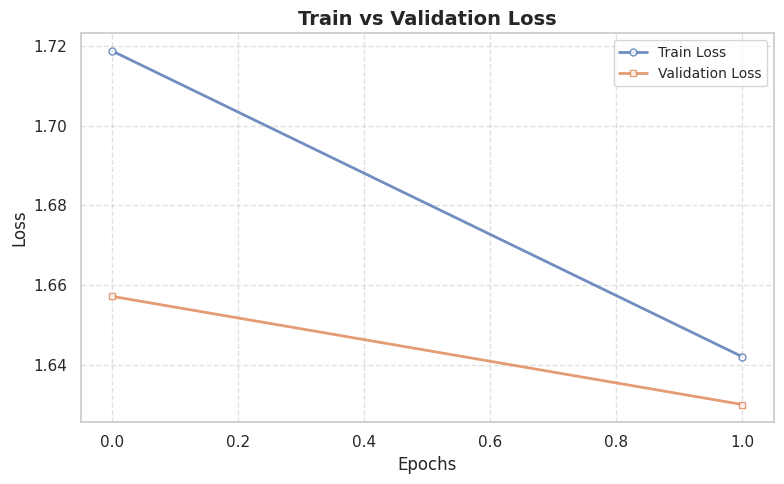

Epoch 3/15 | Train Loss: 1.608489 | Val Loss: 1.591073
New best model saved with val_loss: 1.591073


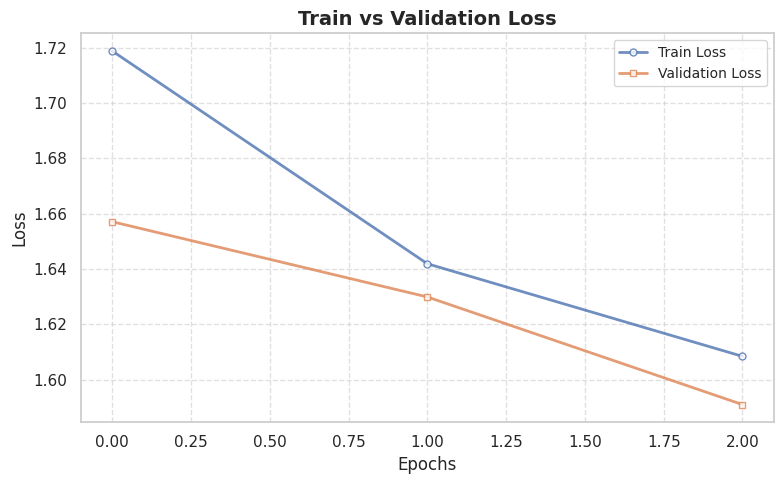

Epoch 4/15 | Train Loss: 1.581474 | Val Loss: 1.587516
New best model saved with val_loss: 1.587516


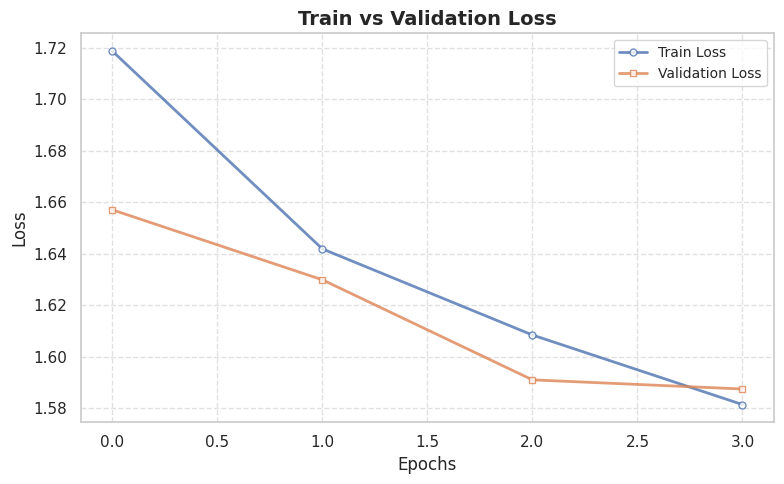

Epoch 5/15 | Train Loss: 1.556518 | Val Loss: 1.592942


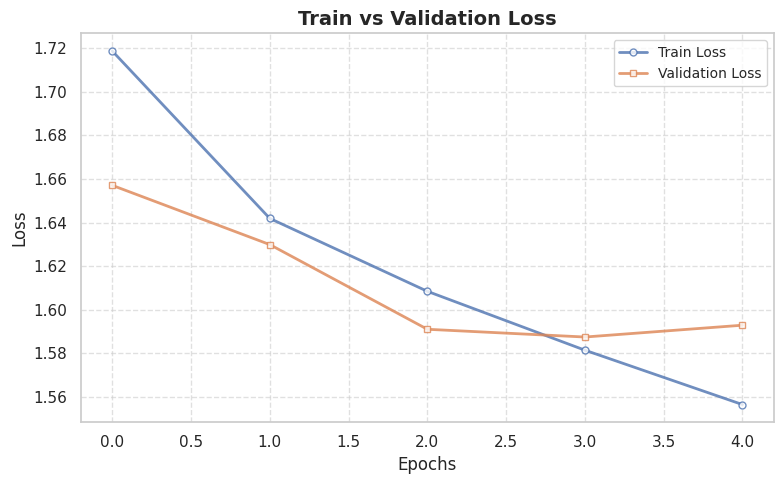

Epoch 6/15 | Train Loss: 1.531434 | Val Loss: 1.563551
New best model saved with val_loss: 1.563551


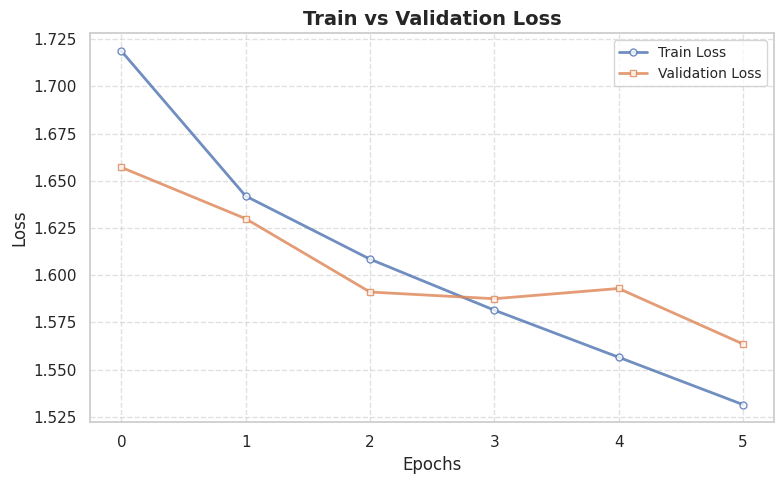

Epoch 7/15 | Train Loss: 1.510554 | Val Loss: 1.577874


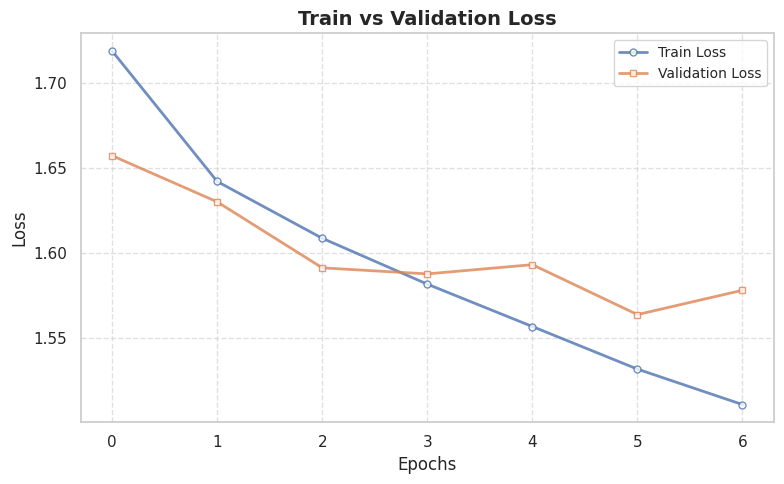

Epoch 8/15 | Train Loss: 1.487025 | Val Loss: 1.572727


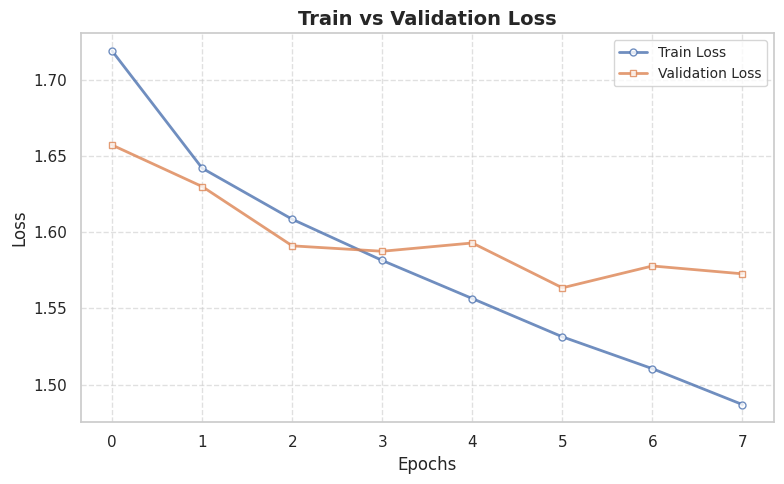

Epoch 9/15 | Train Loss: 1.468565 | Val Loss: 1.556473
New best model saved with val_loss: 1.556473


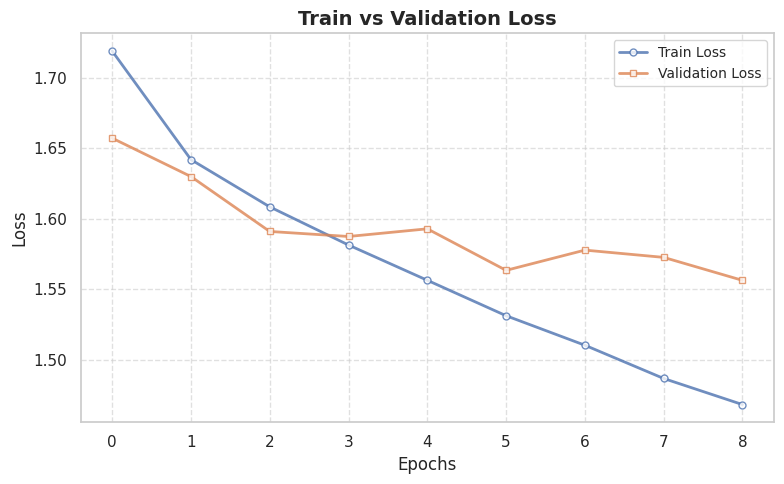

Epoch 10/15 | Train Loss: 1.446012 | Val Loss: 1.573298


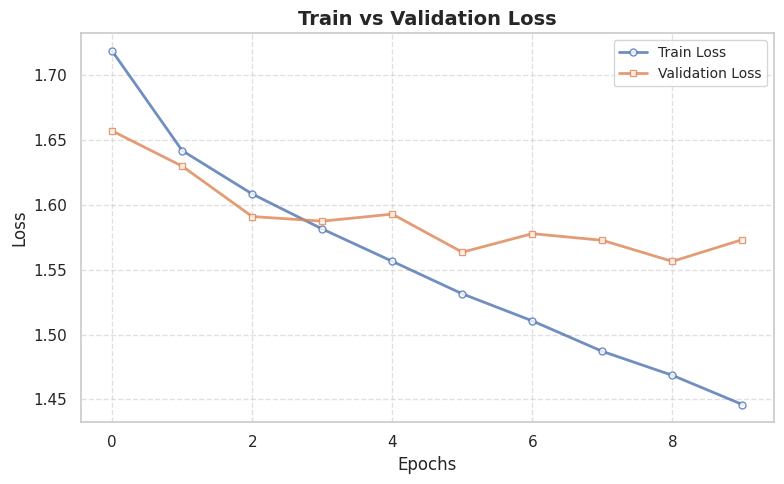

Epoch 11/15 | Train Loss: 1.426326 | Val Loss: 1.561092


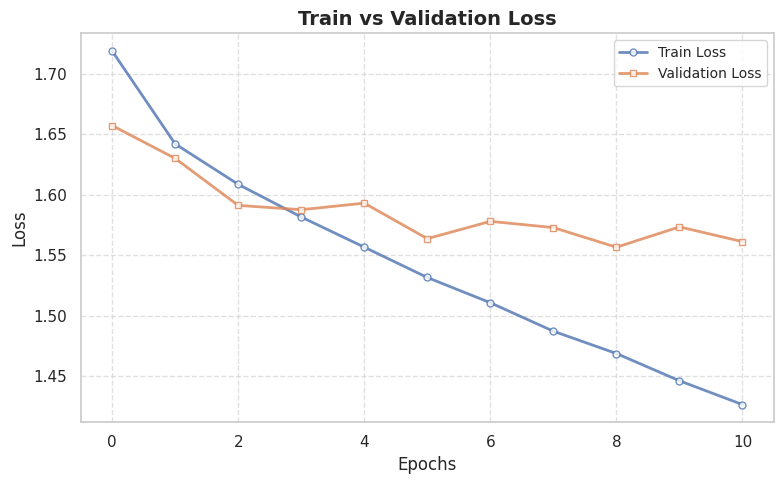

Epoch 12/15 | Train Loss: 1.405219 | Val Loss: 1.550008
New best model saved with val_loss: 1.550008


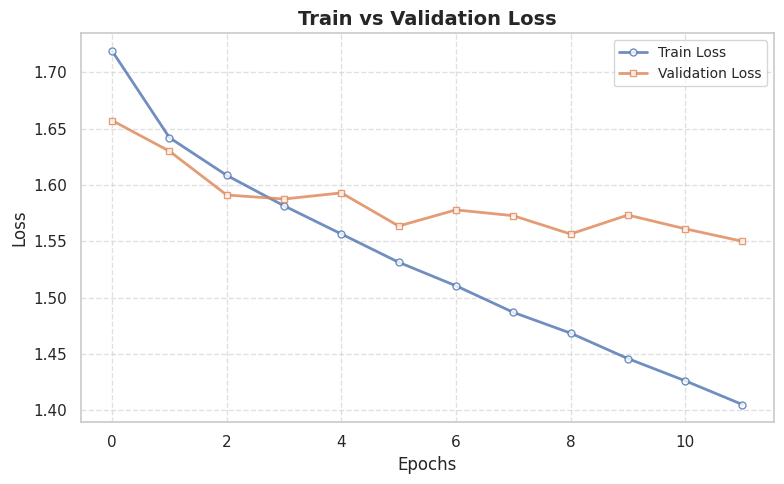

Epoch 13/15 | Train Loss: 1.389564 | Val Loss: 1.554868


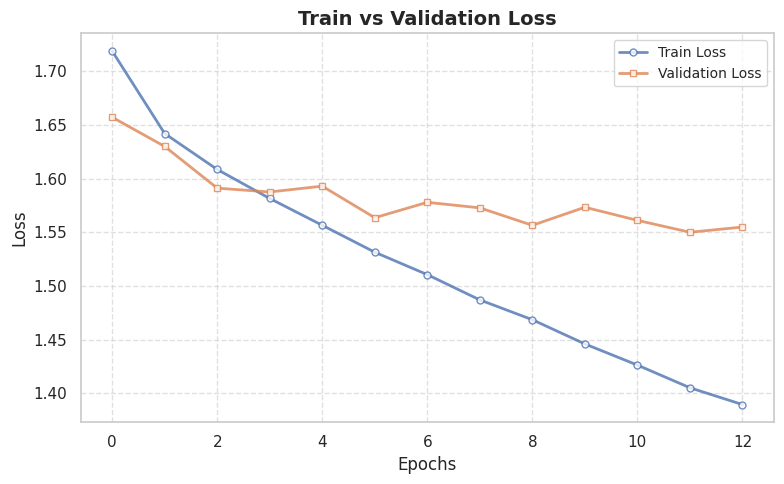

Epoch 14/15 | Train Loss: 1.368892 | Val Loss: 1.553190


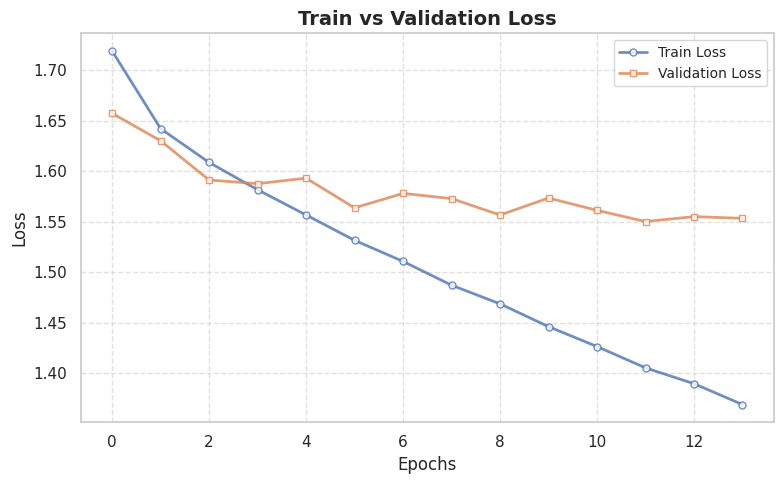

In [ ]:
if __name__ == "__main__":
    train_model()